In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

import wrangle

In [2]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

# Using Time Series Analysis To Predict Cryptocurrency Price Changes

Lori Ainslie, 1/24/22

<hr style="border:2px solid blue"> </hr>

# Executive Summary

## Project Goals

* To use time series analysis to analyze cryptocurrency prices and develop a model that can predict changes in prices.

## Project Description

* Cryptocurrency is a massive and growing industry that provides incredible opportunity for profit but also comes with risk of loss due to its volatility. With models that can identify trends and predict upcoming price changes, these risks can be mitigated.


* The cryptocurrency used in this analysis **~~are HOLO (HOT1-USD) and~~** NEM (XEM-USD). Both have a little over $1B market capitalization at the time of this report. The closing price is what I will be predicting.

<hr style="border:2px solid blue"> </hr>

# Acquisition & Preparation

In [3]:
# use a function to pull in, clean, and split cryptocurrency price data.
cryptocurrency = wrangle.prep_crypto_data()
nem_train, nem_validate, nem_test = pd.DataFrame(cryptocurrency[0][0]),\
                                    pd.DataFrame(cryptocurrency[0][1]),\
                                    pd.DataFrame(cryptocurrency[0][2])
nem_hr_train, nem_hr_validate, nem_hr_test = pd.DataFrame(cryptocurrency[0][3]),\
                                    pd.DataFrame(cryptocurrency[0][4]),\
                                    pd.DataFrame(cryptocurrency[0][5])
holo_train, holo_validate, holo_test = pd.DataFrame(cryptocurrency[1][0]),\
                                    pd.DataFrame(cryptocurrency[1][1]),\
                                    pd.DataFrame(cryptocurrency[1][2])
holo_hr_train, holo_hr_validate, holo_hr_test = pd.DataFrame(cryptocurrency[1][3]),\
                                    pd.DataFrame(cryptocurrency[1][4]),\
                                    pd.DataFrame(cryptocurrency[1][5])

**Steps taken to prepare the data:**

* Became familiar with data (column names, data types, # of observations & features, checked null values, statistical information, and value counts)


* Removed all columns other than target variable (cryptocurrency Close price)


* Data did not have any null values and columns were the correct datatypes


* Used a histogram to check out distribution of Close values


* Created functions to clean and split the data

<hr style="border:2px solid blue"> </hr>

# Exploration

## 1. What trends can we see in the data? Is there a seasonality component?

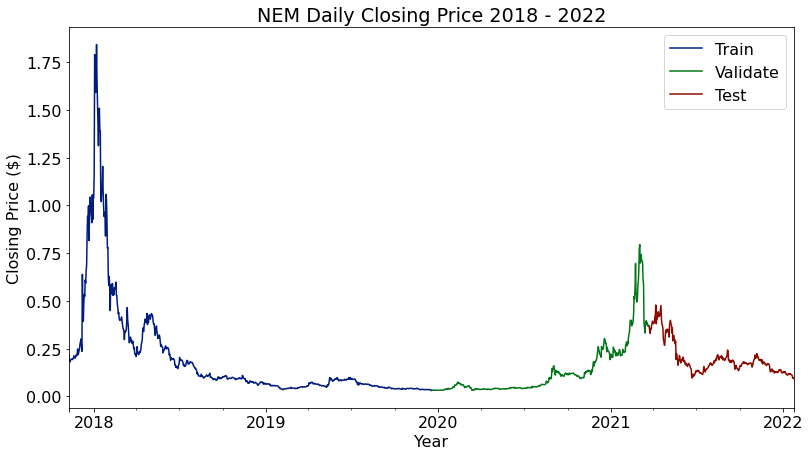

In [4]:
ax = nem_train.plot(label='Train')
nem_validate.plot(ax=ax, label='Validate')
nem_test.plot(ax=ax, label='Test')
ax.set(title='NEM Daily Closing Price 2018 - 2022', xlabel='Year', ylabel='Closing Price ($)')
plt.legend(['Train', 'Validate', 'Test']);

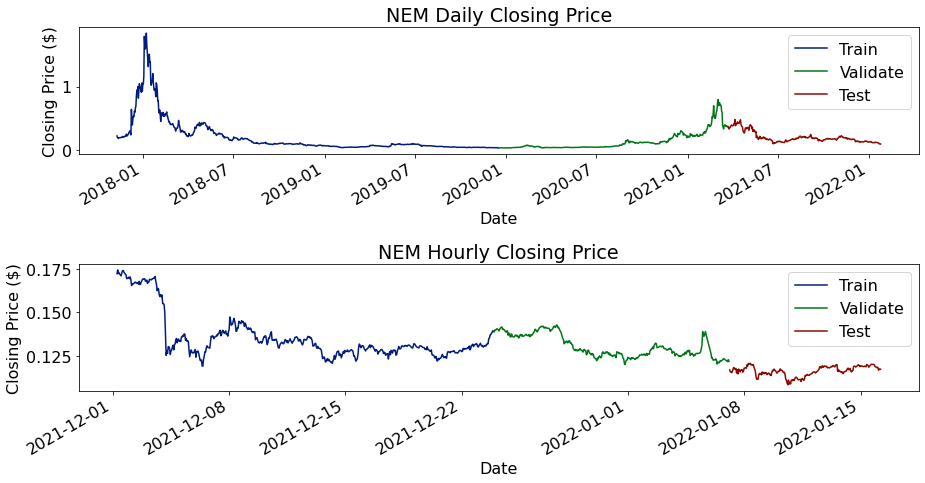

In [5]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(nem_train, label='Train')
nem_validate.plot(ax=ax1, label='Validate')
nem_test.plot(ax=ax1, label='Test')
ax1.set(title='NEM Daily Closing Price', xlabel='Date', ylabel='Closing Price ($)')
ax1.legend(['Train', 'Validate', 'Test'])
ax2.plot(nem_hr_train, label='Train')
nem_hr_validate.plot(ax=ax2, label='Validate')
nem_hr_test.plot(ax=ax2, label='Test')
ax2.set(title='NEM Hourly Closing Price', xlabel='Date', ylabel='Closing Price ($)')
ax2.legend(['Train', 'Validate', 'Test'])
plt.tight_layout();

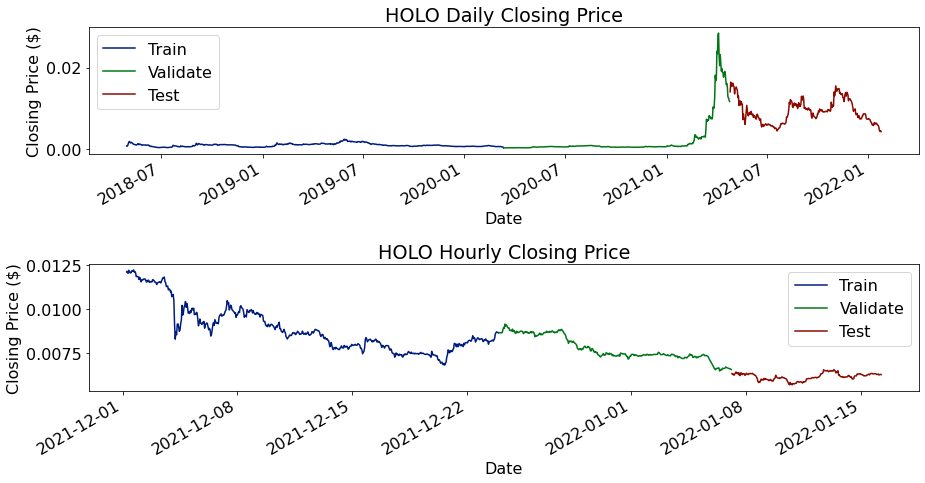

In [6]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(holo_train, label='Train')
holo_validate.plot(ax=ax1, label='Validate')
holo_test.plot(ax=ax1, label='Test')
ax1.set(title='HOLO Daily Closing Price', xlabel='Date', ylabel='Closing Price ($)')
ax1.legend(['Train', 'Validate', 'Test'])
ax2.plot(holo_hr_train, label='Train')
holo_hr_validate.plot(ax=ax2, label='Validate')
holo_hr_test.plot(ax=ax2, label='Test')
ax2.set(title='HOLO Hourly Closing Price', xlabel='Date', ylabel='Closing Price ($)')
ax2.legend(['Train', 'Validate', 'Test'])
plt.tight_layout();

### It appears NEM has stayed fairly steady over the years other than a spike in price during 2018 and 2021 that both dropped back down. There is no evidence of seasonality in the data.

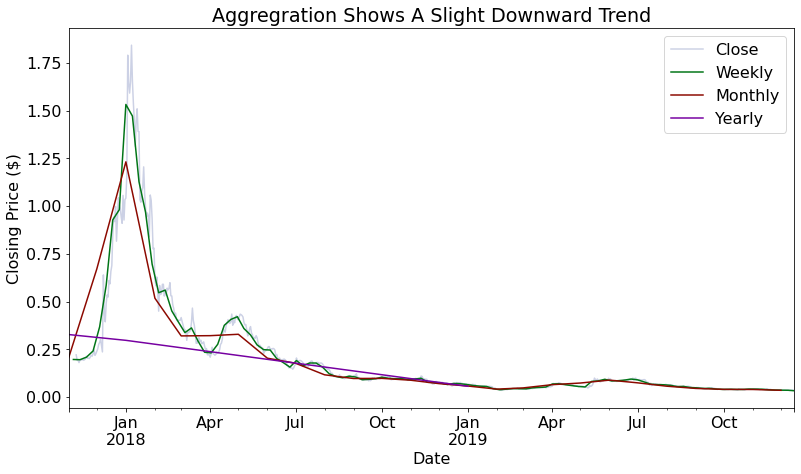

In [7]:
# resample, aggregate, and visualize over various time periods
ax = nem_train.plot(alpha=.2, label='Daily')
nem_train.resample('W').Close.mean().plot(ax=ax, label='Weekly')
nem_train.resample('M').Close.mean().plot(ax=ax, label='Monthly')
nem_train.resample('Y').Close.mean().plot(ax=ax, label='Yearly')
ax.set(title='Aggregration Shows A Slight Downward Trend', xlabel='Date', ylabel='Closing Price ($)', 
       xlim=(pd.Timestamp('2017-11-01'), pd.Timestamp('2019-12-15')))
plt.legend();

### If we focus only on the training dataset and aggregate, therefore smoothing out some of the price movements, we can see a slight downward trend in the data.

***

## 2. Are there any months we can identify as having significantly higher or lower closing prices?

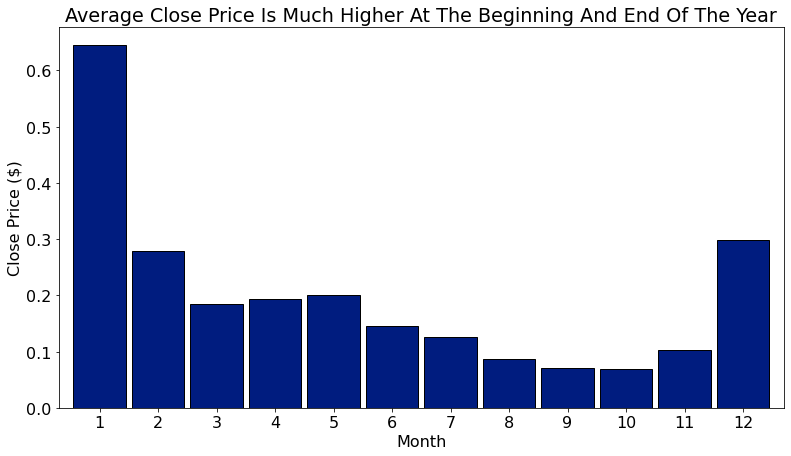

In [8]:
# plot average close price by month for NEM
ax = nem_train.groupby(nem_train.index.month).Close.mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Close Price Is Much Higher At The Beginning And End Of The Year', xlabel='Month', ylabel='Close Price ($)');

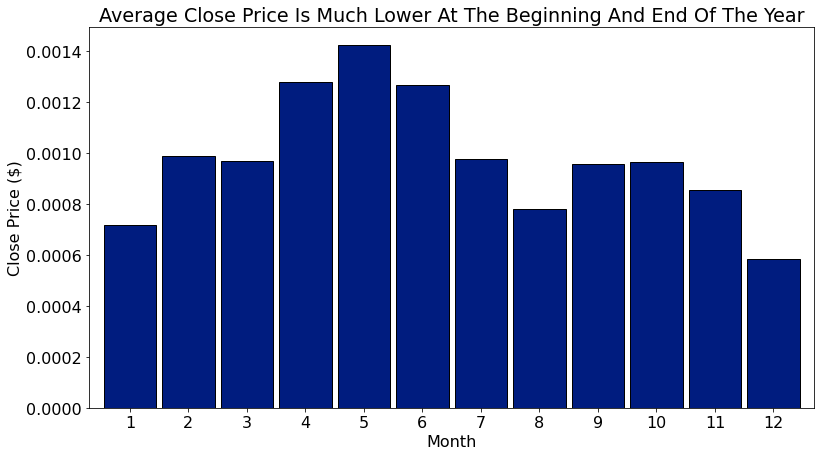

In [9]:
# plot average close price by month for HOLO
ax = holo_train.groupby(holo_train.index.month).Close.mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Close Price Is Much Lower At The Beginning And End Of The Year', xlabel='Month', ylabel='Close Price ($)');

### Grouping by year shows that it could be beneficial to buy NEM cryptocurrency around October and sell during January when prices are highest. This chart, however, is only based on two years' of data and the initial chart showing closing price over the years does not show clear evidence to support this, so I would gather more data before basing any decisions on this result.

***

## 3. Are there any days of the week we can identify as having significantly higher or lower closing prices?

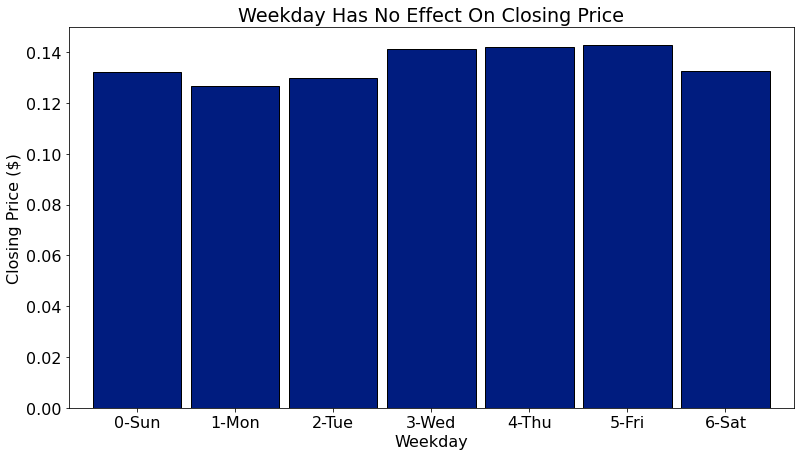

In [10]:
# plot average close price by weekday for NEM
ax = nem_hr_train.groupby(nem_hr_train.index.strftime('%w-%a')).Close.mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Weekday Has No Effect On Closing Price', xlabel='Weekday', ylabel='Closing Price ($)');

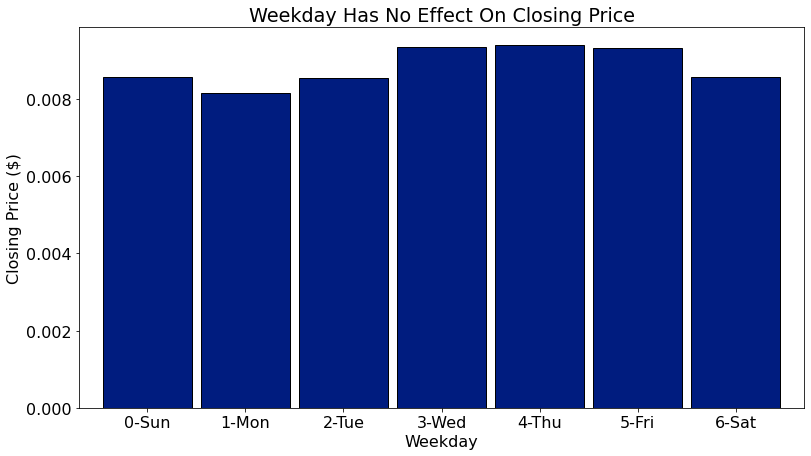

In [11]:
# plot average close price by weekday for NEM
ax = holo_hr_train.groupby(holo_hr_train.index.strftime('%w-%a')).Close.mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Weekday Has No Effect On Closing Price', xlabel='Weekday', ylabel='Closing Price ($)');

### Cryptocurrency markets are open 24/7 which could explain why there is not much variation in average closing price by day of the week. Weekday is not a good indicator of price changes.

***

## Exploration Summary

### - Charts show that NEM cryptocurrency closing prices do not have much seasonality or patterns that can make it easy to predict changes.


### - Due to the relatively steady price other than a few spikes, an autoregressive model based on recent prices is likely the best predictor of price changes.

<hr style="border:2px solid blue"> </hr>

**During modeling, it was discovered that a few hours not been included in the data which produced an error when predictions were made based on a start and end. The number of observations did not align with the number of observations in the validate sets. Therefore, those hours were added and forward filled with the values from the previous hour. Additionally, timezones were removed from the data to prevent errors when making comparisons.**

In [12]:
# use a function to transform hourly data
nem_hr_train, nem_hr_validate, holo_hr_train, holo_hr_validate = wrangle.transform_hourly_data(nem_hr_train, nem_hr_validate, holo_hr_train, holo_hr_validate)

# Modeling

### Establish a baseline 

* The baseline will be the simple average of the train dataset which will be used to make predictions. 
* The root mean square error (RMSE) will be the metric used to evaluate the models. 
* To be of value, any other models will need to beat the RMSE of the baseline model.

In [13]:
# create df object to append evaluation metrics to
eval_df = pd.DataFrame(columns=['model', 'rmse'])

### NEM Closing Price Prediction w/Baseline

Baseline Prediction - Daily  = 0.19956
Baseline Prediction - Hourly  = 0.13582
Baseline Prediction - Daily RMSE: 0.15855
Baseline Prediction - Hourly RMSE: 0.00821


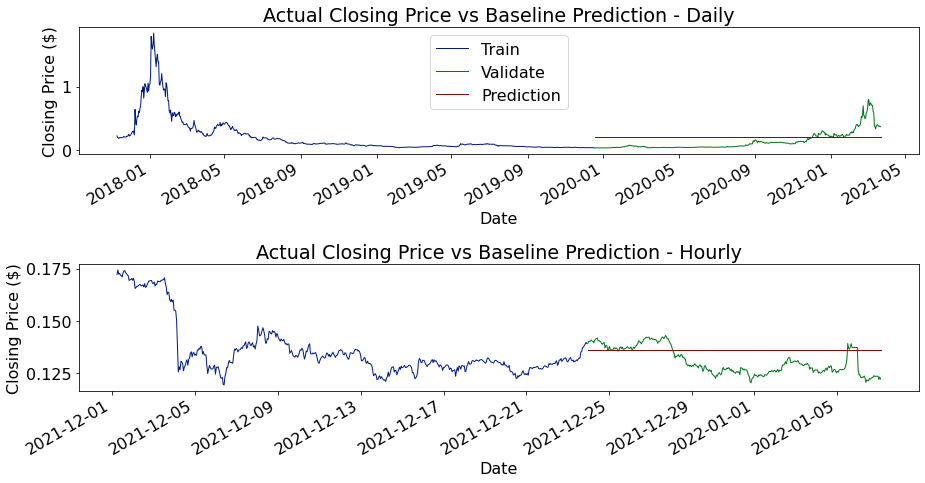

In [14]:
# use function to predict NEM using mean and plot actual vs predicted
eval_df = wrangle.predict_evaluate_baseline(nem_train, nem_validate, nem_hr_train, nem_hr_validate, eval_df)

### HOLO Closing Price Prediction w/Baseline

Baseline Prediction - Daily  = 0.00097
Baseline Prediction - Hourly  = 0.00889
Baseline Prediction - Daily RMSE: 0.00498
Baseline Prediction - Hourly RMSE: 0.00131


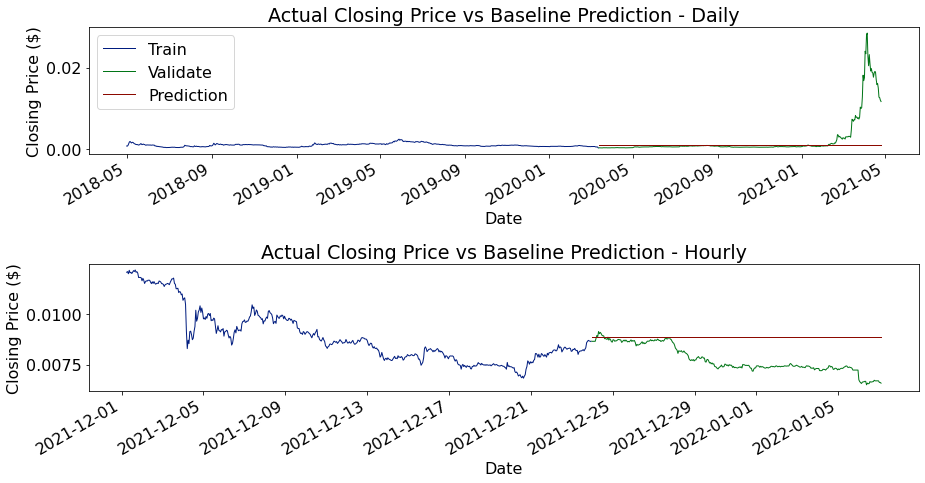

In [15]:
# use function to predict HOLO using mean and plot actual vs predicted
eval_df = wrangle.predict_evaluate_baseline(holo_train, holo_validate, holo_hr_train, holo_hr_validate, eval_df)

### Predict And Evaluate Using Moving Average
* Predictions will be made using the last/most recent values after calculating the 365-day rolling average for the daily data (train dataset) and the 16-hour rolling average for the hourly data (train dataset).

### NEM Closing Price Prediction w/Moving Average

1-Yr Moving Avg  = 0.05681
16-Hr Moving Avg  = 0.13037
1-Yr Moving Avg RMSE: 0.16314
16-Hr Moving Avg RMSE: 0.00637


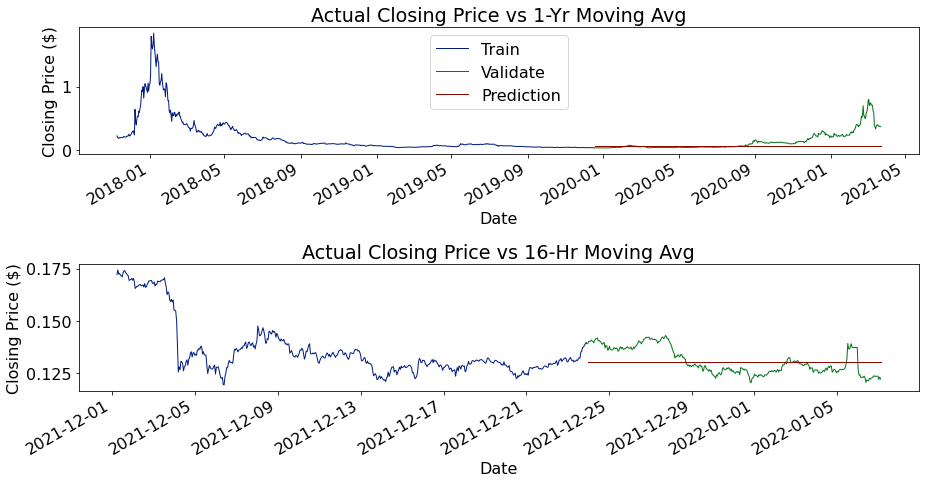

In [16]:
# use function to predict NEM using moving average and plot actual vs predicted
eval_df = wrangle.predict_evaluate_mavg(nem_train, nem_validate, 365, nem_hr_train, nem_hr_validate, 16, eval_df)

### HOLO Closing Price Prediction w/Moving Average

1-Yr Moving Avg  = 0.00105
16-Hr Moving Avg  = 0.00816
1-Yr Moving Avg RMSE: 0.00496
16-Hr Moving Avg RMSE: 0.00078


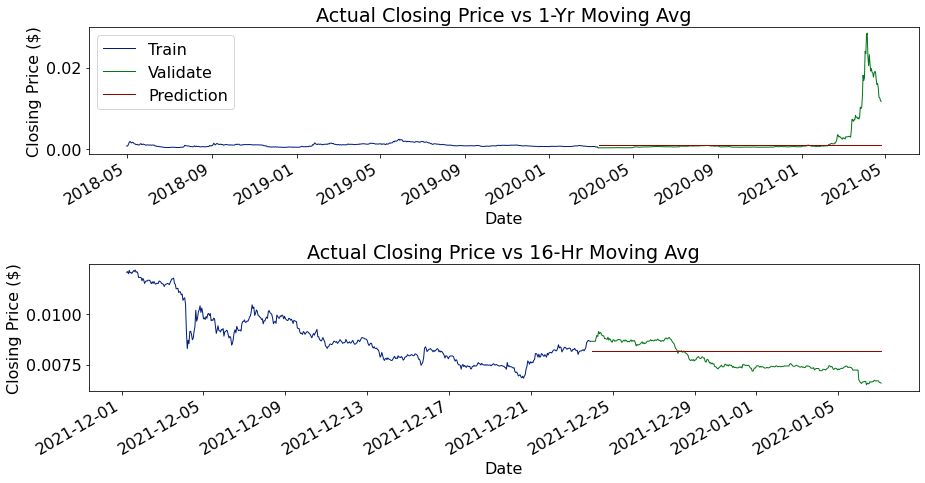

In [17]:
# use function to predict HOLO using moving average and plot actual vs predicted
eval_df = wrangle.predict_evaluate_mavg(holo_train, holo_validate, 365, holo_hr_train, holo_hr_validate, 16, eval_df)

### Predict And Evaluate Using Holt's Linear Trend

### NEM Closing Price Prediction w/Holt's Linear Trend

Holt's Linear Trend - Daily RMSE: 0.38087
Holt's Linear Trend - Hourly RMSE: 0.00953


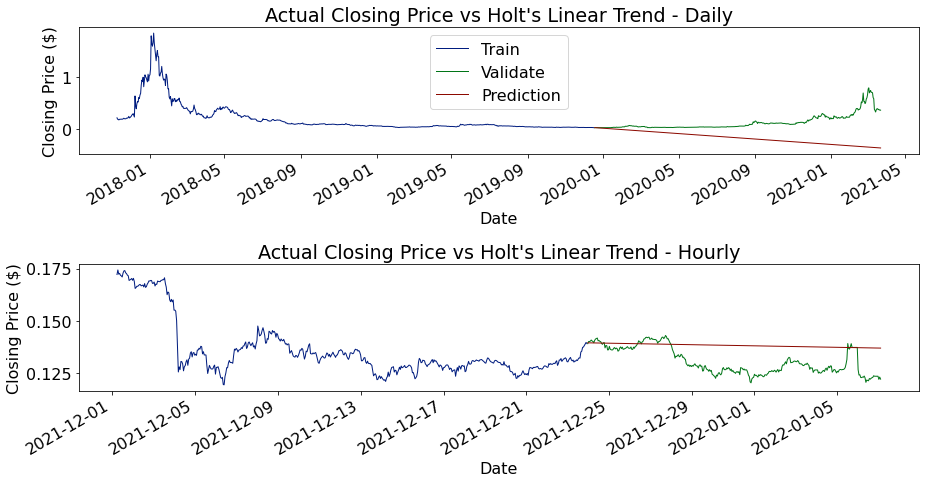

In [18]:
# use function to predict NEM using Holt's Linear Trend and plot actual vs predicted
eval_df = wrangle.predict_evaluate_holts_linear(nem_train, nem_validate, .2, .9, nem_hr_train, nem_hr_validate, .7, .9, eval_df)

### HOLO Closing Price Prediction w/Holt's Linear Trend

Holt's Linear Trend - Daily RMSE: 0.03642
Holt's Linear Trend - Hourly RMSE: 0.00049


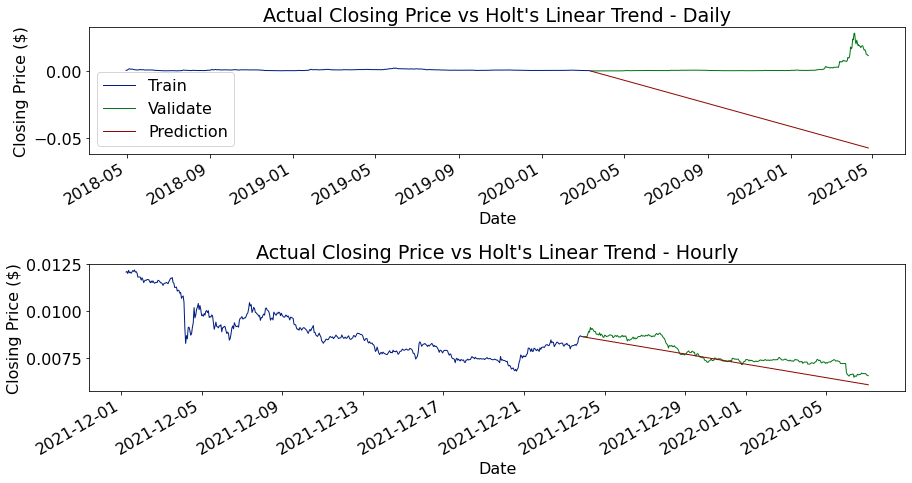

In [19]:
# use function to predict HOLO using Holt's Linear Trend and plot actual vs predicted
eval_df = wrangle.predict_evaluate_holts_linear(holo_train, holo_validate, .7, .9, holo_hr_train, holo_hr_validate, .9, .5, eval_df)

### Predict And Evaluate Using AutoRegressive Integrated Moving Average  (ARIMA)

### NEM Closing Price Prediction w/ARIMA

ARIMA - Daily RMSE: 0.13104
ARIMA - Hourly RMSE: 0.01321


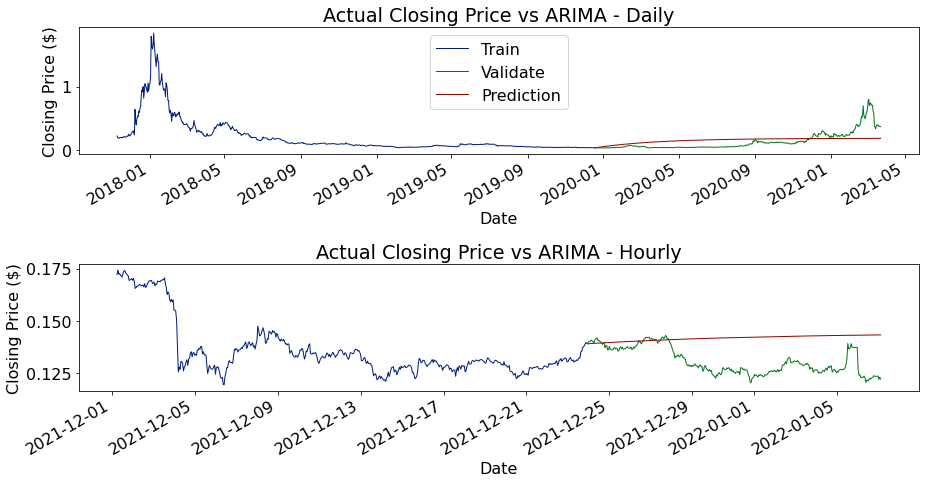

In [20]:
# use function to predict NEM using ARIMA and plot actual vs predicted
eval_df = wrangle.predict_evaluate_arima(nem_train, nem_validate, (5,0,0), nem_hr_train, nem_hr_validate, (0,0,0), eval_df)

### HOLO Closing Price Prediction w/ARIMA

ARIMA - Daily RMSE: 0.00499
ARIMA - Hourly RMSE: 0.00157


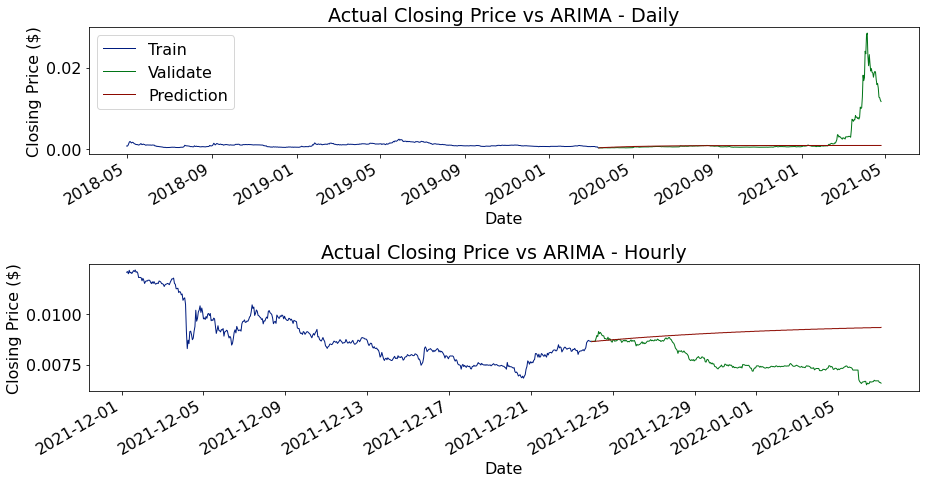

In [21]:
# use function to predict using ARIMA and plot actual vs predicted
eval_df = wrangle.predict_evaluate_arima(holo_train, holo_validate, (5,0,3), holo_hr_train, holo_hr_validate, (0,0,0), eval_df)

In [22]:
# show metrics, order is NEM daily, NEM hourly, HOLO daily, HOLO hourly
eval_df

,model,rmse
0,Baseline Prediction - Daily,0.15855
1,Baseline Prediction - Hourly,0.00821
2,Baseline Prediction - Daily,0.00498
3,Baseline Prediction - Hourly,0.00131
4,1-Yr Moving Avg,0.16314
5,16-Hr Moving Avg,0.00637
6,1-Yr Moving Avg,0.00496
7,16-Hr Moving Avg,0.00078
8,Holt's Linear Trend - Daily,0.38087
9,Holt's Linear Trend - Hourly,0.00953


### Extensive analysis and modeling of two cryptocurrencies using datasets with different time intervals, has proven the complexity of predicting such volatile assets. It appears that having recent data with smaller intervals (hourly vs. daily) provides better results for predicting prices. Overall, moving average and ARIMA seemed to consistently produce the best results but, without more consistent results, I would not use these to make trading decisions.

# Conclusion


## Summary

The goal of this project was:

* To use time series analysis to analyze cryptocurrency prices and develop a model that can predict changes in prices.

I discovered that cryptocurrency does not have much of a seasonality component and therefore is difficult to predict.


## Recommendations

- Gather and implement data such as Google and/or Twitter trends as well as stock market correlations to see if incorporating these provides a better prediction


## Next Steps

- With more time and resources, I would like to gather data from Google searches or trending tweets related to cryptocurrency to see how these affect prices